In [1]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import netCDF4 as nc
import matplotlib.pyplot as plt
from eof import eof, seasonal_sig, interannual_sig, get_wgts, detrend
from analysis import get_gen_chl, get_var, rmse_chl, nrmse_chl, print_map, cross_correlation
from mpl_toolkits.basemap import Basemap,cm 
import glob
from scipy.signal.windows import hann
from matplotlib.ticker import MaxNLocator
from matplotlib import gridspec
import os
import warnings
warnings.filterwarnings("ignore")

### Constants definition 

In [2]:
nlat = 178
nlon = 358
nt = 216
ny = 2016-1998
ndy = 12
nmon = 12
nvar = 12
npara = 7
startY = 1998
endY = 2016
fill_value = -9999.0

d = nc.Dataset("data/INPUT_AI/2004/5/chl_200405.nc")
lats = d.variables["lat"][:]
lons = d.variables["lon"][:]
d.close()

### Loading OCCCI data

In [3]:
def two_numbers_name(file):
    s = file.split("/")
    s[3] = "{:02d}".format(int(s[3]))
    s = '/'.join(s)
    return s

files = glob.glob("data/INPUT_AI/*/*/chl*")
files.sort(key=lambda x:two_numbers_name(x) )
occci_data = []
for file in files:
    nc_data = nc.Dataset(file)
    data = nc_data.variables["chl"][:].data
    data[data == fill_value] = np.NaN
    occci_data.append(data)
    nc_data.close()
occci_data = np.stack(occci_data,axis=0)
occci_data = np.reshape(occci_data,[nt,nlat,nlon])

<h3>Loading MLP Reconstructed data</h3>

In [4]:
mlp_data = get_gen_chl("generated_data/mlp_occci_fixed1998-2016/")
mlp_data[mlp_data == fill_value] = np.NaN
mlp_data = ma.exp(mlp_data)
mlp_data = mlp_data.data

<h3> Loading Input parameters </h3>

In [5]:
sst = get_var("sst")
sla = get_var("sla")
sw = get_var("sw")
uera = get_var("uera")
vera = get_var("vera")
u = get_var("u")
v = get_var("v")

<h4> CrossCorrelation between OCCCI Data and Input Params </h4>

In [7]:
oc_sst = cross_correlation(occci_data, sst)
oc_sla = cross_correlation(occci_data, sla)
oc_sw = cross_correlation(occci_data, sw)
oc_uera = cross_correlation(occci_data, uera)
oc_vera = cross_correlation(occci_data, vera)
oc_u = cross_correlation(occci_data, sst)
oc_v = cross_correlation(occci_data, v)

<h4> CrossCorrelation between MLP Data and Input Params </h4>

In [9]:
mlp_sst = cross_correlation(mlp_data, sst)
mlp_sla = cross_correlation(mlp_data, sla)
mlp_sw = cross_correlation(mlp_data, sw)
mlp_uera = cross_correlation(mlp_data, uera)
mlp_vera = cross_correlation(mlp_data, vera)
mlp_u = cross_correlation(mlp_data, sst)
mlp_v = cross_correlation(mlp_data, v)

In [5]:
def plot_proj1(var,vmin=None,vmax=None):
    parallels = np.arange(-90,90,30.)
    meridians = np.arange(-180,180,30)
    label=""
    m = Basemap(projection='cyl', llcrnrlon=min(lons), llcrnrlat=min(lats), urcrnrlon=max(lons), urcrnrlat=max(lats))    
    x, y = m(*np.meshgrid(lons, lats))
    
    if vmin == None:
        vmin = np.min(var)
    if vmax == None:
        vmax = np.max(var)
        
    clevs = np.linspace(vmin, vmax, 40)

    cs = m.contourf(x, y,var, clevs, cmap=plt.cm.seismic)
    
    m.drawcoastlines()  
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])
    plt.annotate("mean={:02f} ".format(np.nanmean(var)),xy=(min(lons),max(lats)),size=15,
            bbox=dict(boxstyle="round", fc="0.8"))
    return(cs)

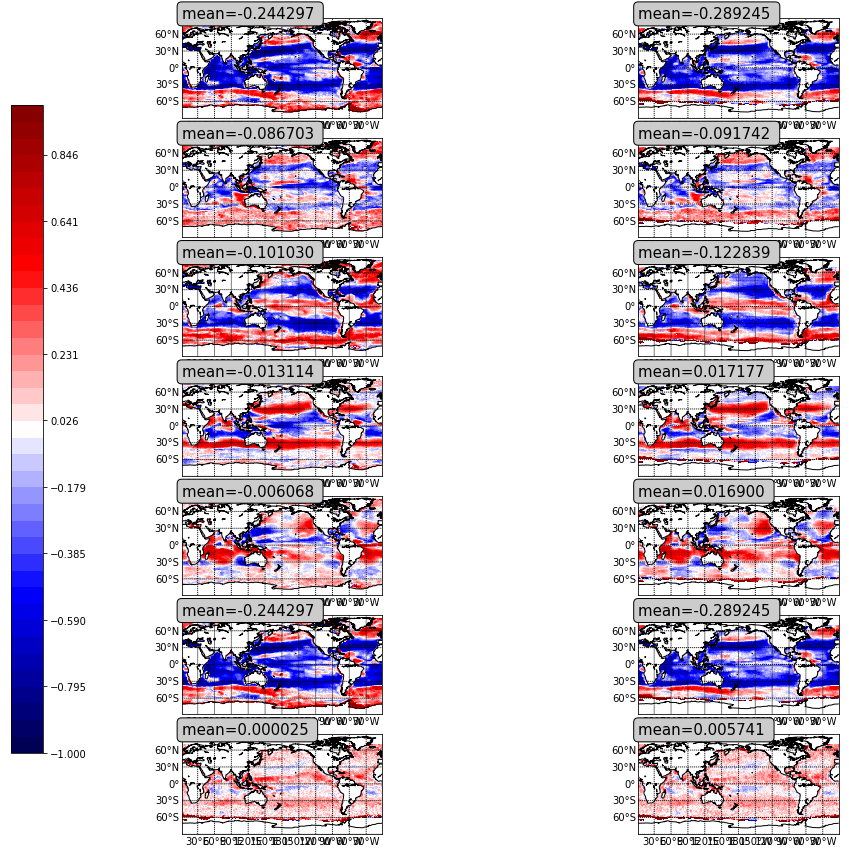

In [65]:
fig = plt.figure(figsize=(15,15))
gs0 = gridspec.GridSpec(7, 2, figure=fig)

plt.subplot(gs0[0])
_ = plot_proj1(oc_sst,vmin=-1,vmax=1)
plt.subplot(gs0[1])
plot_proj1(mlp_sst,vmin=-1,vmax=1)
plt.subplot(gs0[2])
_ = plot_proj1(oc_sla,vmin=-1,vmax=1)
plt.subplot(gs0[3])
plot_proj1(mlp_sla,vmin=-1,vmax=1)
plt.subplot(gs0[4])
_ = plot_proj1(oc_sw,vmin=-1,vmax=1)
plt.subplot(gs0[5])
plot_proj1(mlp_sw,vmin=-1,vmax=1)
plt.subplot(gs0[6])
_ = plot_proj1(oc_uera,vmin=-1,vmax=1)
plt.subplot(gs0[7])
plot_proj1(mlp_uera,vmin=-1,vmax=1)
plt.subplot(gs0[8])
_ = plot_proj1(oc_vera,vmin=-1,vmax=1)
plt.subplot(gs0[9])
plot_proj1(mlp_vera,vmin=-1,vmax=1)
plt.subplot(gs0[10])
_ = plot_proj1(oc_u,vmin=-1,vmax=1)
plt.subplot(gs0[11])
plot_proj1(mlp_u,vmin=-1,vmax=1)
plt.subplot(gs0[12])
cm = plot_proj1(oc_v,vmin=-1,vmax=1)
plt.subplot(gs0[13])
plot_proj1(mlp_v,vmin=-1,vmax=1)




cax= plt.axes([0.05, 0.2, 0.03, 0.6])
cbar = plt.colorbar(cm, cax=cax)
plt.show()

<h3>Removing seasonality </h3>

In [75]:
wgts = get_wgts(lats)

mlp_sig_interan = interannual_sig(mlp_data,nt,ny,ndy,nlat,nlon,wgts)
oc_sig_interan = interannual_sig(occci_data,nt,ny,ndy,nlat,nlon,wgts)


(12, 178, 358)
(12, 178, 358)


In [67]:
oc_sst = cross_correlation(oc_sig_interan, sst)
oc_sla = cross_correlation(oc_sig_interan, sla)
oc_sw = cross_correlation(oc_sig_interan, sw)
oc_uera = cross_correlation(oc_sig_interan, uera)
oc_vera = cross_correlation(oc_sig_interan, vera)
oc_u = cross_correlation(oc_sig_interan, sst)
oc_v = cross_correlation(oc_sig_interan, v)

In [76]:
mlp_sst = cross_correlation(mlp_sig_interan, sst)
mlp_sla = cross_correlation(mlp_sig_interan, sla)
mlp_sw = cross_correlation(mlp_sig_interan, sw)
mlp_uera = cross_correlation(mlp_sig_interan, uera)
mlp_vera = cross_correlation(mlp_sig_interan, vera)
mlp_u = cross_correlation(mlp_sig_interan, sst)
mlp_v = cross_correlation(mlp_sig_interan, v)

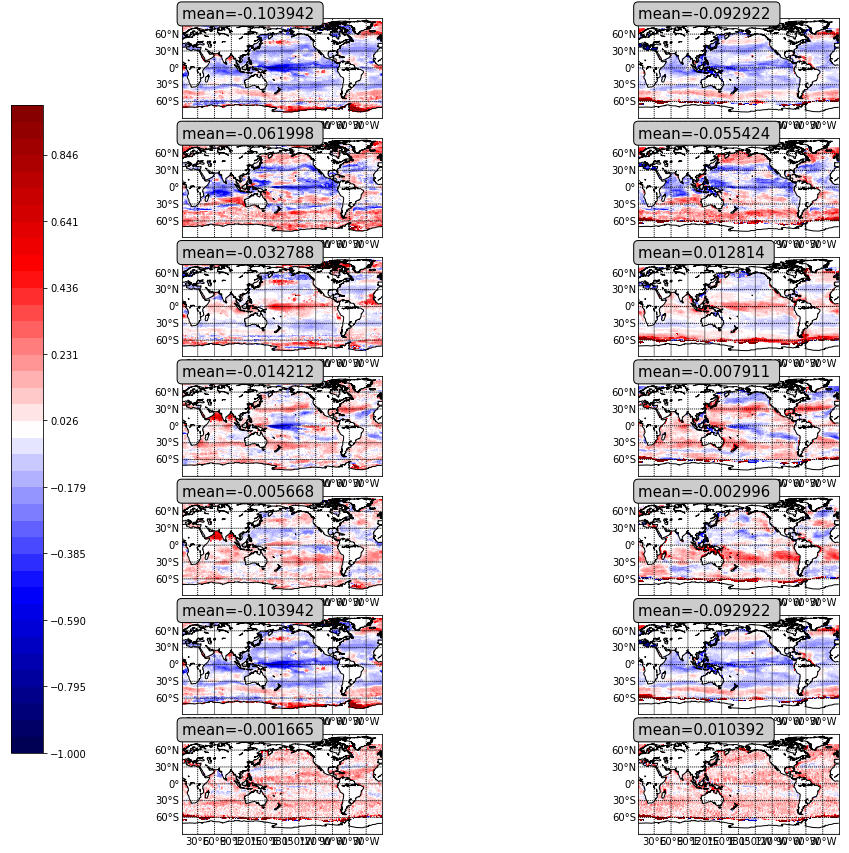

In [77]:
fig = plt.figure(figsize=(15,15))
gs0 = gridspec.GridSpec(7, 2, figure=fig)

plt.subplot(gs0[0])
_ = plot_proj1(oc_sst,vmin=-1,vmax=1)
plt.subplot(gs0[1])
plot_proj1(mlp_sst,vmin=-1,vmax=1)
plt.subplot(gs0[2])
_ = plot_proj1(oc_sla,vmin=-1,vmax=1)
plt.subplot(gs0[3])
plot_proj1(mlp_sla,vmin=-1,vmax=1)
plt.subplot(gs0[4])
_ = plot_proj1(oc_sw,vmin=-1,vmax=1)
plt.subplot(gs0[5])
plot_proj1(mlp_sw,vmin=-1,vmax=1)
plt.subplot(gs0[6])
_ = plot_proj1(oc_uera,vmin=-1,vmax=1)
plt.subplot(gs0[7])
plot_proj1(mlp_uera,vmin=-1,vmax=1)
plt.subplot(gs0[8])
_ = plot_proj1(oc_vera,vmin=-1,vmax=1)
plt.subplot(gs0[9])
plot_proj1(mlp_vera,vmin=-1,vmax=1)
plt.subplot(gs0[10])
_ = plot_proj1(oc_u,vmin=-1,vmax=1)
plt.subplot(gs0[11])
plot_proj1(mlp_u,vmin=-1,vmax=1)
plt.subplot(gs0[12])
cm = plot_proj1(oc_v,vmin=-1,vmax=1)
plt.subplot(gs0[13])
plot_proj1(mlp_v,vmin=-1,vmax=1)




cax= plt.axes([0.05, 0.2, 0.03, 0.6])
cbar = plt.colorbar(cm, cax=cax)
plt.show()

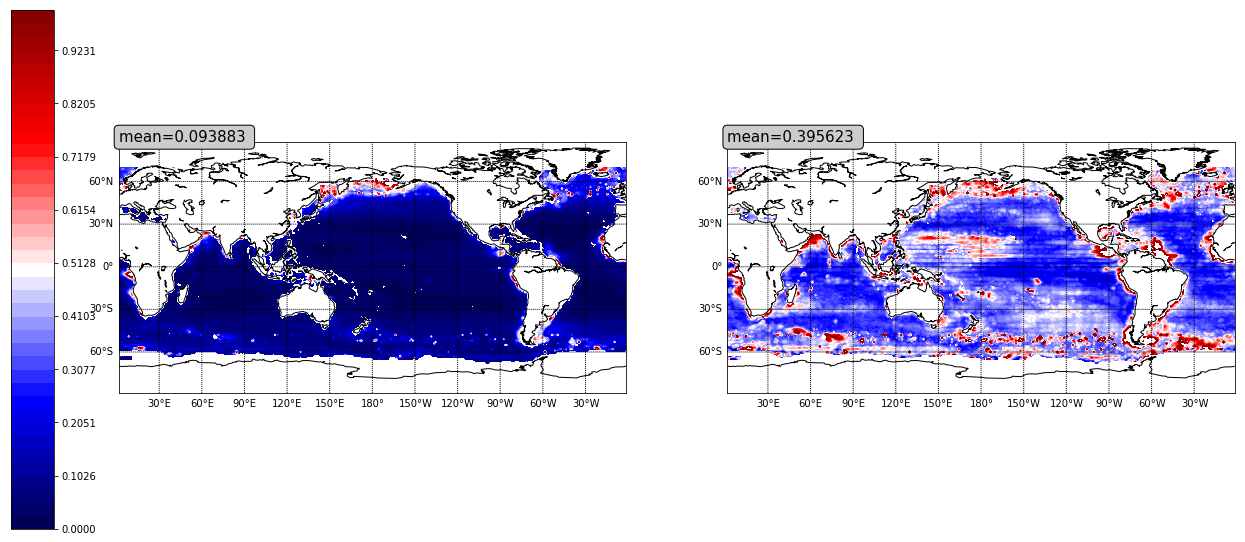

In [14]:
fig = plt.figure(figsize=(20,12))
gs0 = gridspec.GridSpec(1, 2, figure=fig)

plt.subplot(gs0[0])
_ = plot_proj1(rmse_chl(occci_data,mlp_data).data,vmin=0,vmax=1)
plt.subplot(gs0[1])
cm = plot_proj1(nrmse_chl(occci_data,mlp_data).data,vmin=0,vmax=1)



cax= plt.axes([0.05, 0.2, 0.03, 0.6])
cbar = plt.colorbar(cm, cax=cax)
plt.show()